In [1]:
import pandas as pd
import os
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

In [2]:
#returns the testing and training splits of the data
def preprocess(X, target, test_size = 0.2, random_state = 42):
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

    # Drop rows where y_train is NaN
    X_train = X_train[~y_train.isna()]
    y_train = y_train.dropna()

    # Ensure that the indices are aligned
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    return X_train, X_test, y_train, y_test

In [3]:
#model uses gridsearchCV to tune hyperparameters and output the most accurate model
from sklearn.metrics import accuracy_score

def tune_xgb_classifier(X_train, y_train, X_test, y_test, param_grid=None, cv=5, scoring='accuracy', verbose=1):
    """
    Perform grid search on an XGBClassifier model to find the best hyperparameters and calculate accuracy on a test set.
    
    Parameters:
    - X_train: Training data (features)
    - y_train: Training labels (target)
    - X_test: Test data (features)
    - y_test: Test labels (target)
    - param_grid: Dictionary containing the hyperparameters to tune (must be provided)
    - cv: Number of cross-validation folds (default is 5)
    - scoring: Scoring metric for evaluating the model (default is 'accuracy')
    - verbose: Verbosity level (default is 1)
    
    Returns:
    - best_params: The best hyperparameters found by grid search
    - best_score: The best score (accuracy) achieved with those hyperparameters
    - test_accuracy: Accuracy on the test set
    """
    # Create the base model
    xgb = XGBClassifier()
    
    if param_grid is not None:
        # Perform grid search
        grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose)
        grid_search.fit(X_train, y_train)
        
        # Get the best parameters and best cross-validation score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best parameters: {best_params}")
        print(f"Best cross-validation accuracy: {best_score:.2f}")
        
        # Refit the model with the best parameters on the entire training set
        best_model = grid_search.best_estimator_
        
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy on the test set: {test_accuracy * 100:.2f}%')
        
        return best_params, best_score, test_accuracy, best_model
    
    # If no param_grid is provided, fit the default model and calculate accuracy on the test set
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy on the test set: {test_accuracy * 100:.2f}%')
    return None, None, test_accuracy, xgb
    
    

In [4]:
import shap
import matplotlib.pyplot as plt

def shap_plots(model, X_train, plot_type='summary', feature=None, interaction_index=None, school_type=None, title=None, instance_index=0):
    """
    Create SHAP plots for feature importance using the best model from GridSearchCV.
    
    Parameters:
    - model: The trained model (e.g., the best model from GridSearchCV)
    - X_train: The training data used to calculate SHAP values
    - plot_type: Type of SHAP plot to generate ('summary', 'bar', 'dependence', 'force', 'waterfall')
    - feature: The feature name or index to plot (required for 'dependence' plot)
    - interaction_index: The index of the second feature to plot for interaction (optional for 'dependence')
    - school_type: Optional title for distinguishing different school types in the plots
    - title: Custom title for the SHAP plot
    - instance_index: Index of the instance to explain in force or waterfall plots (default: 0)

    Returns:
    - None. The function will display the SHAP plot.
    """
    
    # Create SHAP explainer for tree-based models
    explainer = shap.TreeExplainer(model)
    
    # Compute SHAP values
    shap_values = explainer(X_train)

    # Generate the specified SHAP plot
    if plot_type == 'summary':
        shap.summary_plot(shap_values.values, X_train)
        
    elif plot_type == 'bar':
        shap.summary_plot(shap_values.values, X_train, plot_type="bar")
        
    elif plot_type == 'dependence':
        if feature is None:
            raise ValueError("Feature must be specified for the dependence plot.")
        shap.dependence_plot(feature, shap_values.values, X_train, interaction_index=interaction_index)

    elif plot_type == 'force':
        # Force plot for a specific instance
        shap.initjs()  # Enable JS visualization for notebooks
        display(shap.force_plot(explainer.expected_value, shap_values.values[instance_index], X_train.iloc[instance_index]))

    elif plot_type == 'waterfall':
        # Waterfall plot for a specific instance
        shap.waterfall_plot(shap_values[instance_index])

    else:
        raise ValueError(f"Invalid plot type: {plot_type}. Use 'summary', 'bar', 'dependence', 'force', or 'waterfall'.")

    # Add title if provided
    if title:
        plt.title(title, fontsize=14, fontweight='bold')

    # Add school type title if provided
    if school_type:
        plt.suptitle(school_type, fontsize=16, fontweight='bold')

    # Show the plot
    #plt.show()

# Example usage:
# shap_plots(model, X_train, plot_type="summary")
# shap_plots(model, X_train, plot_type="bar")
# shap_plots(model, X_train, plot_type="dependence", feature="Median Household Income Difference")
# shap_plots(model, X_train, plot_type="force", instance_index=5)
# shap_plots(model, X_train, plot_type="waterfall", instance_index=3)


/opt/anaconda3/envs/nba-pred/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### XGBoost Execution

In [7]:
pd.set_option('display.max_columns', None)  # Show all columns
df = pd.read_csv('/Users/rdhir/Documents/NBAWinPredictions/data/final_data.csv', index_col = 0)

In [8]:
#split data into features and target

X = df.iloc[:, :len(df.columns) - 1]
y = df.iloc[:, len(df.columns) - 1]

In [9]:
#split into test and train split
X_train, X_test, y_train, y_test = preprocess(X, y)

# Define a parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],           # tree complexity
    'learning_rate': [0.01, 0.05, 0.1],   # how fast the model learns (smaller is safer)
    'n_estimators': [100, 200, 300],      # number of trees
    'subsample': [0.7, 0.8, 1.0],         # fraction of data for each boosting round
    'colsample_bytree': [0.7, 0.8, 1.0],  # fraction of features to sample each tree
    'gamma': [0, 1, 5],                   # minimum loss reduction to split a node
    'reg_alpha': [0, 0.1, 1],             # L1 regularization (sparsity control)
    'reg_lambda': [1, 1.5, 2]             # L2 regularization (overfitting control)
}


In [10]:
from xgboost import XGBClassifier

# 1. Initialize model (default settings)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 2. Fit (train) the model
model.fit(X_train, y_train)

# 3. Predict (optional step afterward)
y_pred = model.predict(X_test)


/opt/anaconda3/envs/nba-pred/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:06:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056754219/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [11]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.5524193548387096


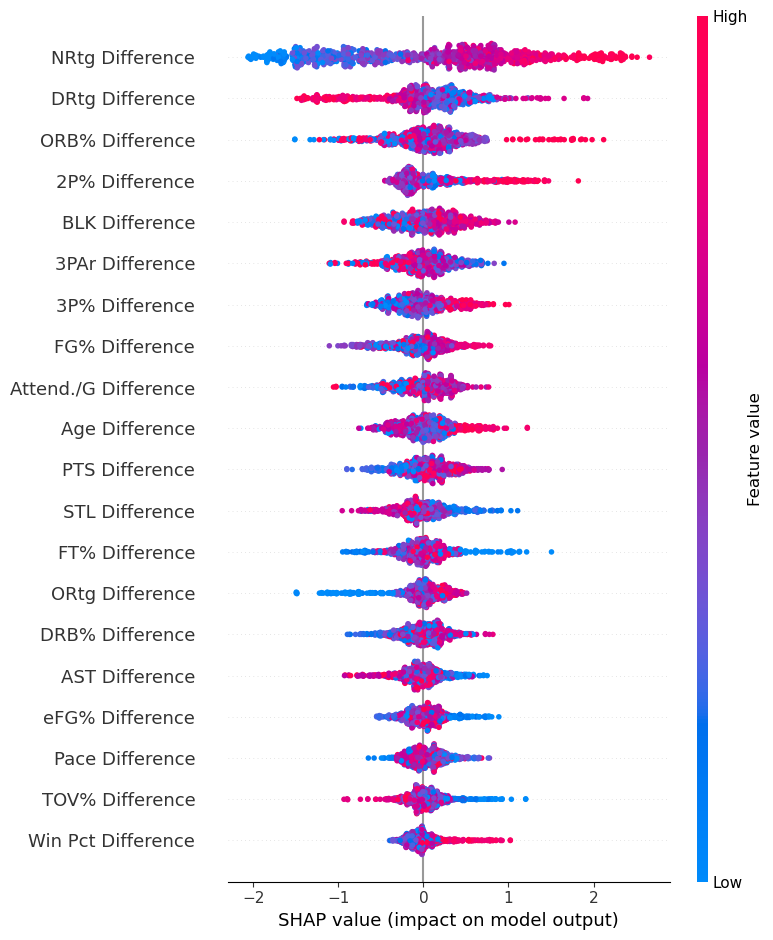

In [17]:
shap_plots(model, X_train, plot_type="summary")

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(models, X_tests, y_tests, model_names):
    fig, axes = plt.subplots(1, len(models), figsize=(5, 5))

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    axes.set_title(model_names[0])
    axes.set_xlabel("Predicted")
    axes.set_ylabel("Actual")

    plt.show()

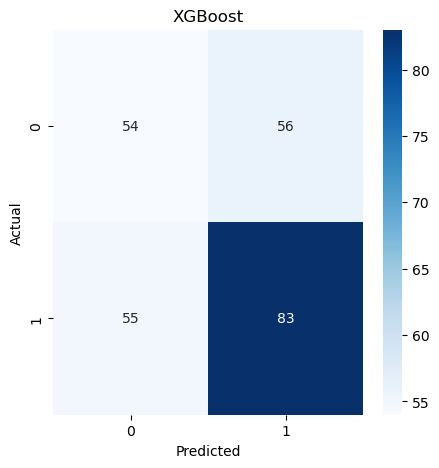

In [22]:
plot_confusion_matrices([model], [X_test], [y_test], ["XGBoost"])

In [29]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_xgb_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates a single XGBoost model and returns a styled performance table.

    Parameters:
    - model: Trained XGBoost model.
    - X_test: Test features.
    - y_test: True test labels.
    - model_name: Optional name for the model (default: "Model").

    Returns:
    - A styled pandas Styler object with Accuracy, Precision, Recall, F1 Score, and AUC-ROC.
    """

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # For AUC

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "AUC-ROC": roc_auc_score(y_test, y_prob)
    }

    df = pd.DataFrame(metrics, index=[model_name])

    styled = df.style.format("{:.3f}").set_caption("📊 Model Performance Summary").set_table_styles([
        {'selector': 'thead th', 'props': [('background-color', '#6b2626'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'tbody', 'props': [('background-color', '#3d6cf2')]},
        {'selector': 'td', 'props': [('color', 'black')]}
    ])

    return styled

# Example usage:
# display(evaluate_xgb_model(model, X_test, y_test, model_name="Full Model"))

In [30]:
display(evaluate_xgb_model(model, X_test, y_test, model_name="XGBoost"))

,Accuracy,Precision,Recall,F1 Score,AUC-ROC
XGBoost,0.552,0.597,0.601,0.599,0.597


In [20]:
import joblib

# Save the trained model
joblib.dump(model, 'nba_model.pkl')

['nba_model.pkl']

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Save the scaler to use in the Streamlit app
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [23]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

# Define base XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Calibrate using isotonic regression (more flexible, slower) or sigmoid (Platt scaling)
calibrated_model = CalibratedClassifierCV(estimator=xgb, method='isotonic', cv=5)

# Fit model
calibrated_model.fit(X_train_scaled, y_train)

# Save the calibrated model
joblib.dump(calibrated_model, 'nba_model.pkl')


/opt/anaconda3/envs/nba-pred/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:19:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056754219/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/nba-pred/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:19:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056754219/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/nba-pred/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:19:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1745056754219/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/nba-pred/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:

['nba_model.pkl']